# Data Extraction (Part 1)


Data Extraction Workflow: <https://cookbook.openai.com/examples/data_extraction_transformation>

In [2]:
from pyhere import here
from IPython.display import display_markdown

from openai import OpenAI
import pymupdf
import io
import os
from PIL import Image
import base64
import json

api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)

## Extract PDF to base64 image

In [3]:
@staticmethod
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

In [4]:
def pdf_to_base64_images(pdf_path):
    # Handles PDFs with multiple pages
    import pymupdf
    
    pdf_document = pymupdf.open(pdf_path)
    base64_images = []
    temp_image_paths = []

    total_pages = len(pdf_document)

    for page_num in range(total_pages):
        page = pdf_document.load_page(page_num)
        pix = page.get_pixmap()
        img = Image.open(io.BytesIO(pix.tobytes()))
        temp_image_path = f"temp_page_{page_num}.png"
        img.save(temp_image_path, format="PNG")
        temp_image_paths.append(temp_image_path)
        base64_image = encode_image(temp_image_path)
        base64_images.append(base64_image)

    for temp_image_path in temp_image_paths:
        os.remove(temp_image_path)

    return base64_images

In [5]:
# Test Run
img_base64_1 = pdf_to_base64_images(here("pdf/invoice/20190119_002.pdf"))

## How To

### Extract text from a PDF

[PyMuPDF](https://pymupdf.readthedocs.io/en/latest/the-basics.html)

In [6]:
import pymupdf

doc = pymupdf.open(here("pdf/invoice/20190119_002.pdf")) 
out = open("output.txt", "wb") # create a text output
out

<_io.BufferedWriter name='output.txt'>

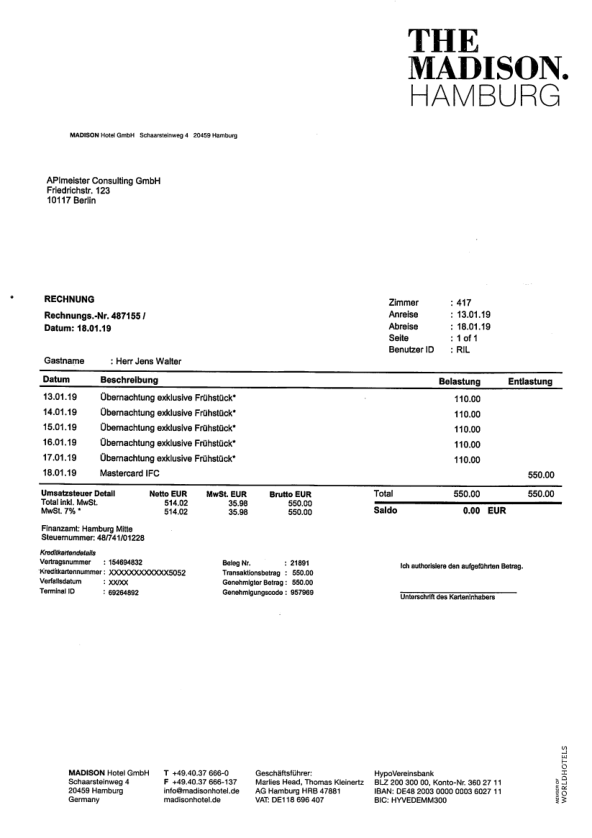

In [7]:
# Load Page
page = doc.load_page(0)
pix = page.get_pixmap()
img = Image.open(io.BytesIO(pix.tobytes()))
img

## Extract one PDF

In [11]:
def extract_invoice_data(base64_image):
    system_prompt = f"""
    You are an OCR-like data extraction tool that extracts hotel invoice data from PDFs.
   
    1. Please extract the data in this hotel invoice, grouping data according to theme/sub groups, and then output into JSON.

    2. Please keep the keys and values of the JSON in the original language. 

    3. The type of data you might encounter in the invoice includes but is not limited to: hotel information, guest information, invoice information,
    room charges, taxes, and total charges etc. 

    4. If the page contains no charge data, please output an empty JSON object and don't make up any data.

    5. If there are blank data fields in the invoice, please include them as "null" values in the JSON object.
    
    6. If there are tables in the invoice, capture all of the rows and columns in the JSON object. 
    Even if a column is blank, include it as a key in the JSON object with a null value.
    
    7. If a row is blank denote missing fields with "null" values. 
    
    8. Don't interpolate or make up data.

    9. Please maintain the table structure of the charges, i.e. capture all of the rows and columns in the JSON object.

    """
    
    response = client.chat.completions.create(
        model="gpt-4o",
        response_format={ "type": "json_object" },
        messages=[
            {
                "role": "system",
                "content": system_prompt
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "extract the data in this hotel invoice and output into JSON "},
                    {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{base64_image}", "detail": "high"}}
                ]
            }
        ],
        temperature=0.0,
    )
    return response.choices[0].message.content


In [12]:
img_base64_1_json = extract_invoice_data(img_base64_1)

In [13]:
img_base64_1_dict = json.loads(img_base64_1_json) 
img_base64_1_dict.get("Hotel Information")

{'Name': 'MADISON Hotel GmbH',
 'Address': 'Schaarsteinweg 4, 20459 Hamburg',
 'Contact': {'Phone': '+49-40-37 666-0',
  'Fax': '+49-40-37 666-137',
  'Email': 'info@madisonhotel.de',
  'Website': 'madisonhotel.de'},
 'Geschäftsführer': 'Marlies Head, Thomas Kleinertz',
 'AG': 'Hamburg HRB 47821',
 'VAT': 'DE118 696 407',
 'Bank': {'Name': 'HypoVereinsbank',
  'BLZ': '200 300 00',
  'Konto-Nr': '360 27 11',
  'IBAN': 'DE48 2003 0000 0036 6027 11',
  'BIC': 'HYVEDEMM300'}}

## Extract All PDFs

Because invoice data can span multiple pages in a PDF, we're going to produce JSON objects for each page in the invoice and then append them together. The final invoice extraction will be a single JSON file.

In [47]:
def extract_from_multiple_pages(base64_images, original_filename, output_directory):
    entire_invoice = []

    for base64_image in base64_images:
        invoice_json = extract_invoice_data(base64_image)
        invoice_data = json.loads(invoice_json)
        entire_invoice.append(invoice_data)

    # Ensure the output directory exists
    os.makedirs(output_directory, exist_ok=True)

    # Construct the output file path
    output_filename = os.path.join(output_directory, original_filename.replace('.pdf', '_extracted.json'))
    
    # Save the entire_invoice list as a JSON file
    with open(output_filename, 'w', encoding='utf-8') as f:
        json.dump(entire_invoice, f, ensure_ascii=False, indent=4)
    return output_filename


def main_extract(read_path, write_path):
    for filename in os.listdir(read_path):
        file_path = os.path.join(read_path, filename)
        if os.path.isfile(file_path):
            base64_images = pdf_to_base64_images(file_path)
            extract_from_multiple_pages(base64_images, filename, write_path)


In [48]:
main_extract(read_path = here("pdf/invoice"), write_path = here("output/json/extracted_invoice_json"))

## Data Lake of JSON

In [60]:
invoices_list = []
json_dir_path = here("output/json/extracted_invoice_json")

for f in os.listdir(json_dir_path):
    print(f)
    with open(os.path.join(json_dir_path, f), 'r') as file:
        invoice_dict = json.load(file)
        invoices_list.append(invoice_dict)
        
invoices_list

citadines-20190331_Invoice_extracted.json
20190119_002_extracted.json
20190202_THE MADISON HAMBURG_extracted.json


[[{'Rechnungsadresse': {'Name': 'APImeis\xadter Consulting GmbH',
    'Adresse': 'Friedrichstrasse 123',
    'Stadt': '10117 Berlin',
    'Land': 'Germany'},
   'Gastname': 'Herr Jens Walter',
   'Reservierungsnr.': '1221737070-1',
   'Apartment Nr.': '420',
   'Apartment Typ': '1-Bedroom',
   'Anreisedatum': '31/03/2019',
   'Abreisedatum': '05/04/2019',
   'Rechnungsnr.': '083-72561',
   'Rechnungsdatum': '05/04/19 - 09:46',
   'Bediener': 'DE-GB',
   'Seite': '1 von 1',
   'Tabelle': [{'DATUM': '31/03/19',
     'APT NR.': '420',
     'BESCHREIBUNG': 'Apartment 31/03/19#420',
     'EURO': '92,56'},
    {'DATUM': '01/04/19',
     'APT NR.': '420',
     'BESCHREIBUNG': 'Apartment 01/04/19#420',
     'EURO': '197,20'},
    {'DATUM': '02/04/19',
     'APT NR.': '420',
     'BESCHREIBUNG': 'Apartment 02/04/19#420',
     'EURO': '254,15'},
    {'DATUM': '03/04/19',
     'APT NR.': '420',
     'BESCHREIBUNG': 'Apartment 03/04/19#420',
     'EURO': '215,90'},
    {'DATUM': '04/04/19',
     '

In [65]:
len(invoices_list)

3

In [66]:
invoices_list

[[{'Rechnungsadresse': {'Name': 'APImeis\xadter Consulting GmbH',
    'Adresse': 'Friedrichstrasse 123',
    'Stadt': '10117 Berlin',
    'Land': 'Germany'},
   'Gastname': 'Herr Jens Walter',
   'Reservierungsnr.': '1221737070-1',
   'Apartment Nr.': '420',
   'Apartment Typ': '1-Bedroom',
   'Anreisedatum': '31/03/2019',
   'Abreisedatum': '05/04/2019',
   'Rechnungsnr.': '083-72561',
   'Rechnungsdatum': '05/04/19 - 09:46',
   'Bediener': 'DE-GB',
   'Seite': '1 von 1',
   'Tabelle': [{'DATUM': '31/03/19',
     'APT NR.': '420',
     'BESCHREIBUNG': 'Apartment 31/03/19#420',
     'EURO': '92,56'},
    {'DATUM': '01/04/19',
     'APT NR.': '420',
     'BESCHREIBUNG': 'Apartment 01/04/19#420',
     'EURO': '197,20'},
    {'DATUM': '02/04/19',
     'APT NR.': '420',
     'BESCHREIBUNG': 'Apartment 02/04/19#420',
     'EURO': '254,15'},
    {'DATUM': '03/04/19',
     'APT NR.': '420',
     'BESCHREIBUNG': 'Apartment 03/04/19#420',
     'EURO': '215,90'},
    {'DATUM': '04/04/19',
     '